In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashwita21bai1346
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign


100%|██████████| 325M/325M [00:01<00:00, 232MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Flatten,Dropout
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.applications import ResNet50, DenseNet121, VGG16, EfficientNetB0, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import datetime


In [3]:
base_model_inception=InceptionV3(input_shape=(256,256,3),include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [4]:
base_model_resnet = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


94765736/94765736 [==============================] - 0s 0us/step


In [5]:
base_model_densenet = DenseNet121(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


29084464/29084464 [==============================] - 0s 0us/step


In [6]:
base_model_vgg16 = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [7]:
base_model_efficientnetb0=EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [8]:
base_model_xception=Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

83683744/83683744 [==============================] - 4s 0us/step


In [9]:
from keras.layers import Input

def build_custom_cnn_improved():
    model = Sequential([
        # Input Layer with resizing to 124x124
        Input(shape=(256, 256, 3)),  # Define input explicitly
        tf.keras.layers.Resizing(124, 124),

        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
# Dictionary to store base models
base_models = {
    "inceptionv3": base_model_inception,
    "resnet50": base_model_resnet,
    "densenet121": base_model_densenet,
    "vgg16": base_model_vgg16,
    "efficientnetb0": base_model_efficientnetb0,
    "xception": base_model_xception
}

# Set all layers to non-trainable for each base model
for model_name, base_model in base_models.items():
    for layer in base_model.layers:
        layer.trainable = False


In [11]:
def create_model(base_model):
    # Add custom layers to the base model
    X = Flatten()(base_model.output)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(units=2, activation='sigmoid')(X)

    # Create the final model
    model = Model(base_model.input, X)
    model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return model

models = {}
for model_name, base_model in base_models.items():
    print(f"\nBuilding model for: {model_name}")
    models[model_name] = create_model(base_model)
    models[model_name].summary()


Building model for: inceptionv3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0  

In [12]:
train_datagen=ImageDataGenerator(#featurewise_center=True,
                                 rotation_range=0.4,
                                 width_shift_range=0.3,
                                 horizontal_flip=True,
                                 preprocessing_function=preprocess_input,
                                 zoom_range=0.4,
                                 shear_range=0.4)
train_data=train_datagen.flow_from_directory(directory='/content/skin-cancer-malignant-vs-benign/train',
                                             target_size=(256,256),
                                             batch_size=32)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,)
val_data=test_datagen.flow_from_directory(directory='/content/skin-cancer-malignant-vs-benign/test',
                                             target_size=(256,256),
                                             batch_size=32)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'benign': 0, 'malignant': 1}

In [14]:
val_data.class_indices

{'benign': 0, 'malignant': 1}

In [15]:
# Use Python's built-in next() function to fetch the next batch
t_img, label = next(train_data)


In [16]:
t_img.shape

(32, 256, 256, 3)

In [17]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [18]:
# Create InceptionV3 model
base_model_inception = base_models["inceptionv3"]
model_inception = create_model(base_model_inception)

# Fit the model
his_inception = model_inception.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="inceptionv3")]
)


Saving TensorBoard log files to: tensorflow_hub/inceptionv3/20241117-044013
Epoch 1/10
5/5 [==============================] - 12s 2s/step - loss: 44.5162 - accuracy: 0.4437 - val_loss: 46.1604 - val_accuracy: 0.5344
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 26.1726 - accuracy: 0.5813 - val_loss: 4.8008 - val_accuracy: 0.6531
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 14.2680 - accuracy: 0.4688 - val_loss: 3.0149 - val_accuracy: 0.7594
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 5.4987 - accuracy: 0.6625 - val_loss: 7.4399 - val_accuracy: 0.6219
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 3.3431 - accuracy: 0.7625 - val_loss: 2.6351 - val_accuracy: 0.7719
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 3.1132 - accuracy: 0.7312 - val_loss: 3.6968 - val_accuracy: 0.7219
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 2.9772 - accuracy: 0.7500 - 

In [19]:
# Create resnet model
base_model_resnet = base_models["resnet50"]
model_resnet = create_model(base_model_resnet)

# Fit the model
his_resnet = model_resnet.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50")]
)


Saving TensorBoard log files to: tensorflow_hub/resnet50/20241117-044124
Epoch 1/10
5/5 [==============================] - 19s 4s/step - loss: 46.4967 - accuracy: 0.4313 - val_loss: 3.9044 - val_accuracy: 0.5531
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: 8.4724 - accuracy: 0.5125 - val_loss: 3.4403 - val_accuracy: 0.4625
Epoch 3/10
5/5 [==============================] - 15s 3s/step - loss: 3.6360 - accuracy: 0.5562 - val_loss: 1.5050 - val_accuracy: 0.7188
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 2.6435 - accuracy: 0.6000 - val_loss: 2.1724 - val_accuracy: 0.4437
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 2.7527 - accuracy: 0.5390 - val_loss: 1.0602 - val_accuracy: 0.7188
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 2.3391 - accuracy: 0.6438 - val_loss: 1.4554 - val_accuracy: 0.6531
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 1.6150 - accuracy: 0.7250 - 

In [20]:
# Create InceptionV3 model
base_model_densenet = base_models["densenet121"]
model_densenet = create_model(base_model_densenet)

# Fit the model
his_densenet = model_densenet.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="densenet121")]
)


Saving TensorBoard log files to: tensorflow_hub/densenet121/20241117-044358
Epoch 1/10
5/5 [==============================] - 23s 4s/step - loss: 24.9274 - accuracy: 0.5188 - val_loss: 8.2079 - val_accuracy: 0.7250
Epoch 2/10
5/5 [==============================] - 14s 3s/step - loss: 4.9045 - accuracy: 0.8000 - val_loss: 4.7461 - val_accuracy: 0.7469
Epoch 3/10
5/5 [==============================] - 14s 3s/step - loss: 5.0020 - accuracy: 0.7688 - val_loss: 2.9600 - val_accuracy: 0.8156
Epoch 4/10
5/5 [==============================] - 14s 3s/step - loss: 4.3827 - accuracy: 0.7312 - val_loss: 3.9852 - val_accuracy: 0.7531
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 3.4604 - accuracy: 0.7500 - val_loss: 1.4261 - val_accuracy: 0.8531
Epoch 6/10
5/5 [==============================] - 13s 3s/step - loss: 3.0386 - accuracy: 0.7312 - val_loss: 1.8839 - val_accuracy: 0.8094
Epoch 7/10
5/5 [==============================] - 13s 3s/step - loss: 2.5225 - accuracy: 0.8369

In [21]:
# Create vgg16 model
base_model_vgg16 = base_models["vgg16"]
model_vgg16 = create_model(base_model_vgg16)

# Fit the model
his_vgg16 = model_vgg16.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="vgg16")]
)


Saving TensorBoard log files to: tensorflow_hub/vgg16/20241117-044623
Epoch 1/10
5/5 [==============================] - 14s 3s/step - loss: 3.0603 - accuracy: 0.6250 - val_loss: 1.8997 - val_accuracy: 0.8094
Epoch 2/10
5/5 [==============================] - 12s 3s/step - loss: 1.4504 - accuracy: 0.7812 - val_loss: 1.1153 - val_accuracy: 0.8344
Epoch 3/10
5/5 [==============================] - 12s 3s/step - loss: 1.1642 - accuracy: 0.7625 - val_loss: 1.0573 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 12s 3s/step - loss: 0.7631 - accuracy: 0.8062 - val_loss: 0.6645 - val_accuracy: 0.8000
Epoch 5/10
5/5 [==============================] - 12s 3s/step - loss: 1.0512 - accuracy: 0.7812 - val_loss: 0.5364 - val_accuracy: 0.7969
Epoch 6/10
5/5 [==============================] - 12s 3s/step - loss: 0.8784 - accuracy: 0.7875 - val_loss: 0.8502 - val_accuracy: 0.6969
Epoch 7/10
5/5 [==============================] - 12s 3s/step - loss: 0.8437 - accuracy: 0.7063 - val_

In [22]:
# Create the Custom CNN model
model_custom_cnn = build_custom_cnn_improved()

# Fit the Custom CNN model
his_custom_cnn = model_custom_cnn.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="custom_cnn_improved")]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 124, 124, 3)       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 124, 124, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 31, 31, 128)       7

In [23]:
# Create xception model
base_model_xception = base_models["xception"]
model_xception = create_model(base_model_xception)

# Fit the model
his_xception = model_xception.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="xception")]
)


Saving TensorBoard log files to: tensorflow_hub/xception/20241117-044910
Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 27.1743 - accuracy: 0.5437 - val_loss: 5.6558 - val_accuracy: 0.6906
Epoch 2/10
5/5 [==============================] - 12s 3s/step - loss: 10.8653 - accuracy: 0.5750 - val_loss: 9.3806 - val_accuracy: 0.6031
Epoch 3/10
5/5 [==============================] - 12s 3s/step - loss: 4.5437 - accuracy: 0.6750 - val_loss: 2.6721 - val_accuracy: 0.7719
Epoch 4/10
5/5 [==============================] - 12s 3s/step - loss: 2.6216 - accuracy: 0.7312 - val_loss: 2.4395 - val_accuracy: 0.7594
Epoch 5/10
5/5 [==============================] - 12s 3s/step - loss: 3.1086 - accuracy: 0.6938 - val_loss: 2.0263 - val_accuracy: 0.7469
Epoch 6/10
5/5 [==============================] - 12s 3s/step - loss: 1.6646 - accuracy: 0.8125 - val_loss: 1.7605 - val_accuracy: 0.7688
Epoch 7/10
5/5 [==============================] - 12s 3s/step - loss: 1.2177 - accuracy: 0.7937 -

In [24]:
# Create efficientnet model
base_model_efficientnetb0 = base_models["efficientnetb0"]
model_efficientnetb0 = create_model(base_model_efficientnetb0)

# Fit the model
his_efficientnetb0 = model_efficientnetb0.fit(
    train_data,
    epochs=10,
    steps_per_epoch=5,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetb0")]
)


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20241117-045113
Epoch 1/10
5/5 [==============================] - 18s 2s/step - loss: 26.8862 - accuracy: 0.5188 - val_loss: 26.9148 - val_accuracy: 0.4781
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 18.2120 - accuracy: 0.5125 - val_loss: 19.9915 - val_accuracy: 0.5375
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 12.5899 - accuracy: 0.4688 - val_loss: 5.4952 - val_accuracy: 0.4563
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 5.9912 - accuracy: 0.5250 - val_loss: 5.9707 - val_accuracy: 0.4437
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 4.5826 - accuracy: 0.5375 - val_loss: 1.6454 - val_accuracy: 0.5437
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 4.6402 - accuracy: 0.4750 - val_loss: 2.8785 - val_accuracy: 0.5344
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 4.4256 - accuracy: 0.525

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
tf.keras.models.save_model(model,'/content/gdrive/MyDrive/skincancerinception.h5')

<ipython-input-16-5aa2398ae7c5>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'/content/gdrive/MyDrive/skincancerinception.h5')


In [ ]:
from keras.models import load_model
model=load_model("/content/gdrive/MyDrive/skincancerinception.h5")

In [ ]:
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
val_class_indices = val_data.classes

# Convert the class indices to original class labels
class_labels = {v: k for k, v in val_data.class_indices.items()}
val_original_labels = [class_labels[idx] for idx in val_class_indices]

print("Original labels of validation data:")
print(val_original_labels)

Original labels of validation data:
['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'be

In [26]:
# Dictionary to store model predictions
model_predictions = {}

# List of models and their names
models = {
    "inception": model_inception,
    "resnet50": model_resnet,
    "densenet": model_densenet,
    "vgg16": model_vgg16,
    "efficientnet": model_efficientnetb0,
    "xception": model_xception,
    "custom_cnn": model_custom_cnn
}

# Make predictions for all models
for model_name, model_instance in models.items():
    print(f"Generating predictions for {model_name}...")
    y_preds = model_instance.predict(val_data, verbose=1)  # Use predict() instead of predict_generator
    model_predictions[model_name] = y_preds


Generating predictions for inception...
21/21 [==============================] - 7s 236ms/step
Generating predictions for resnet50...
21/21 [==============================] - 17s 745ms/step
Generating predictions for densenet...
21/21 [==============================] - 18s 783ms/step
Generating predictions for vgg16...
21/21 [==============================] - 15s 715ms/step
Generating predictions for efficientnet...
21/21 [==============================] - 11s 447ms/step
Generating predictions for xception...
21/21 [==============================] - 13s 586ms/step
Generating predictions for custom_cnn...
21/21 [==============================] - 2s 86ms/step


In [27]:
# Dictionary to store model predictions and class mappings
model_predictions_classes = {}

# Generate predictions and map to classes
for model_name, model_instance in models.items():
    print(f"Generating predictions and classes for {model_name}...")
    y_preds = model_instance.predict(val_data, verbose=1)  # Predict probabilities
    y_pred_classes = [np.argmax(element) for element in y_preds]  # Convert probabilities to class indices
    y_pred_classes = ["benign" if x == 0 else "malignant" for x in y_pred_classes]  # Map indices to class names
    model_predictions_classes[model_name] = y_pred_classes


Generating predictions and classes for inception...
21/21 [==============================] - 5s 246ms/step
Generating predictions and classes for resnet50...
21/21 [==============================] - 15s 728ms/step
Generating predictions and classes for densenet...
21/21 [==============================] - 16s 760ms/step
Generating predictions and classes for vgg16...
21/21 [==============================] - 15s 712ms/step
Generating predictions and classes for efficientnet...
21/21 [==============================] - 9s 417ms/step
Generating predictions and classes for xception...
21/21 [==============================] - 12s 560ms/step
Generating predictions and classes for custom_cnn...
21/21 [==============================] - 2s 82ms/step


In [ ]:
y_pred_classes

['maligant',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'benign',
 'maligant',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'maligant',
 'benign',
 'maligant',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'maligant',
 'benign',
 'maligant',
 'maligant',
 'maligant',
 'maligant',
 'maligant',
 'maligant',
 'benign',
 'benign',
 'benign',
 'benign',
 'maligant',
 'benign',
 'benign',
 'benign',
 'maligant',
 'maligant',
 'maligant',
 'benign',
 '

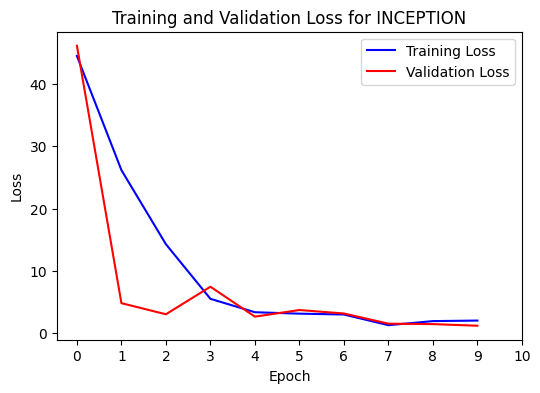

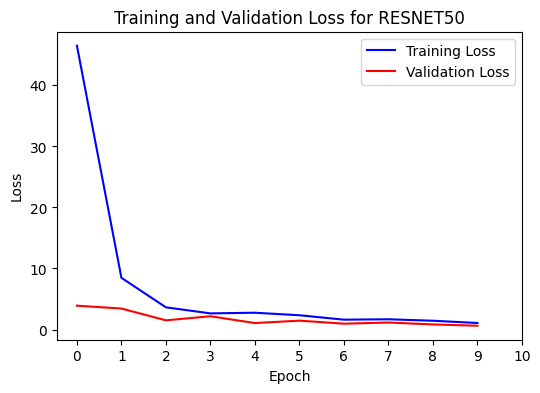

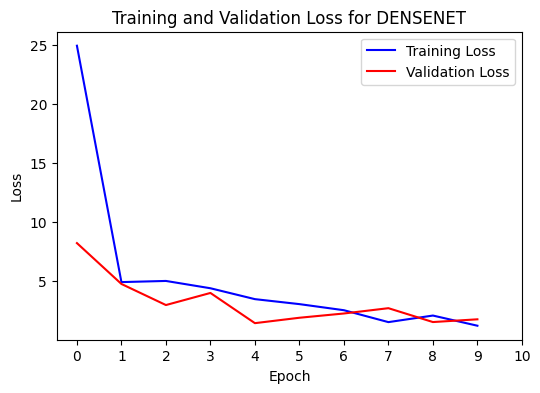

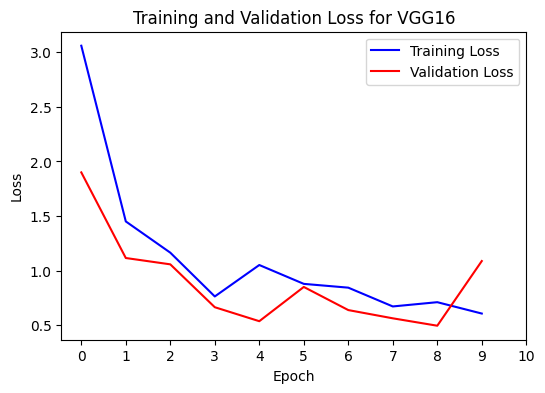

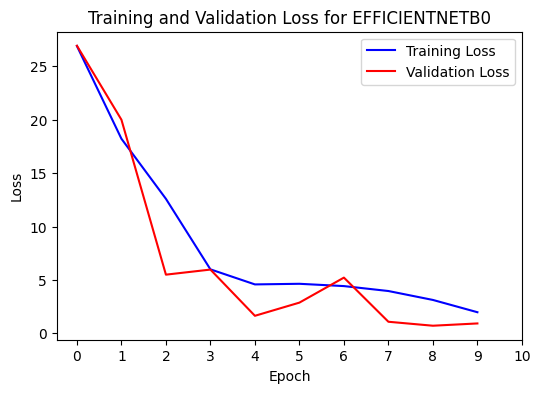

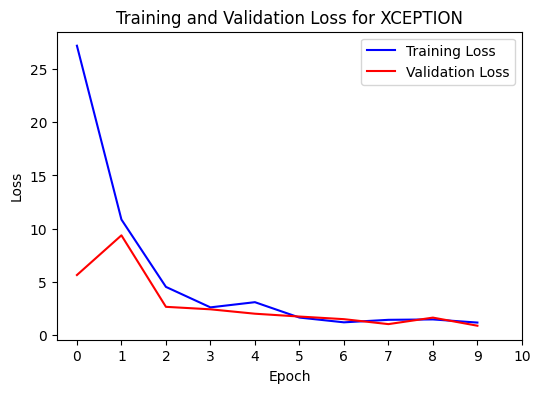

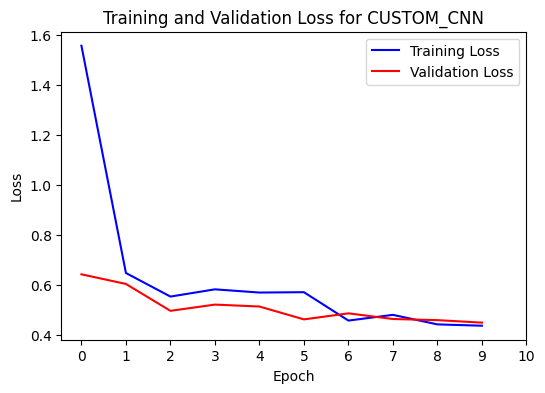

In [53]:
# Dictionary to store histories of all models
model_histories = {
    "inception": his_inception.history,
    "resnet50": his_resnet.history,
    "densenet": his_densenet.history,
    "vgg16": his_vgg16.history,
    "efficientnetb0": his_efficientnetb0.history,
    "xception": his_xception.history,
    "custom_cnn": his_custom_cnn.history
}

# Loop through each model's history and plot loss
for model_name, history in model_histories.items():
    plt.figure(figsize=(6, 4))
    plt.plot(history['loss'], label='Training Loss', c='blue')
    plt.plot(history['val_loss'], label='Validation Loss', c='red')
    plt.title(f'Training and Validation Loss for {model_name.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history['loss']) + 1, 1))  # Adjust range dynamically based on epochs
    plt.legend()
    plt.show()


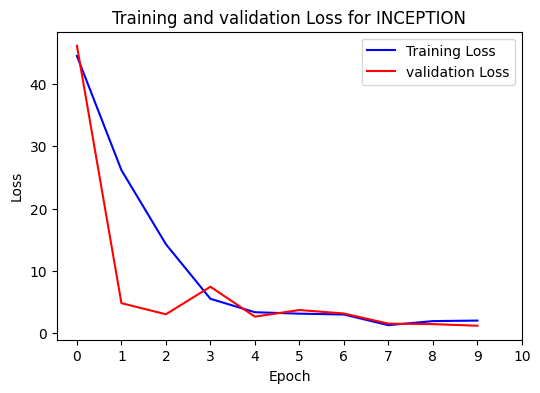

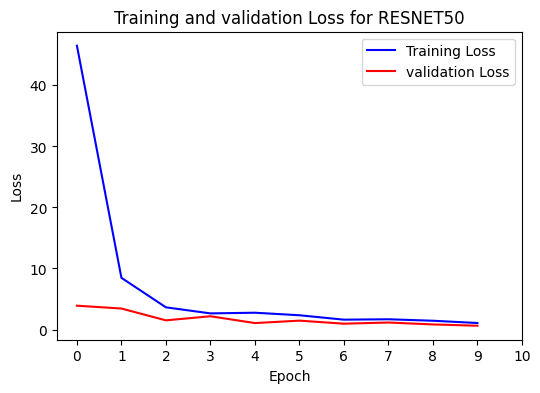

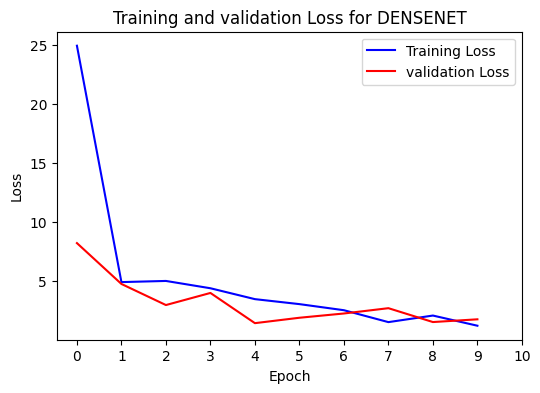

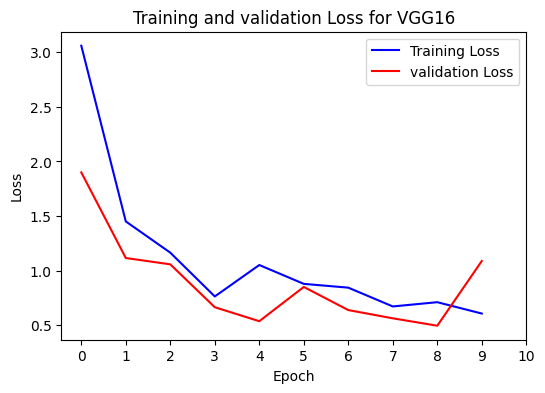

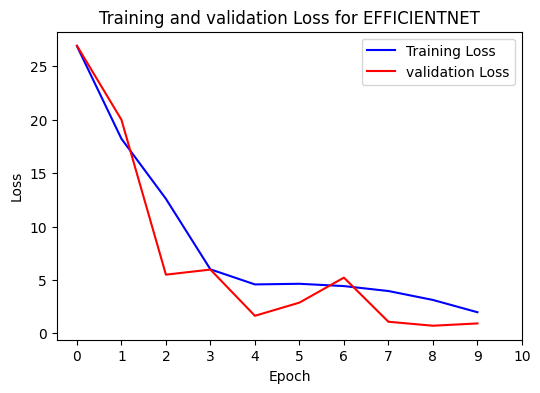

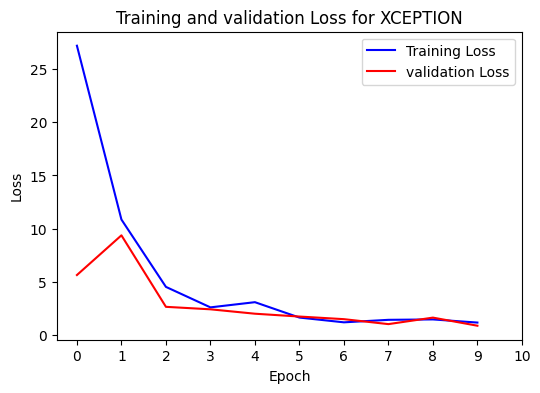

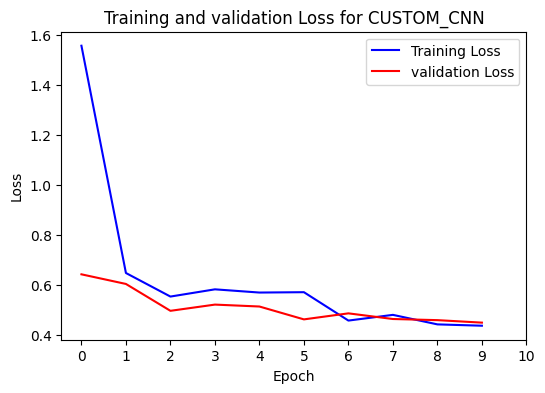

In [29]:
for model_name, history in model_histories.items():
    plt.figure(figsize=(6, 4))
    plt.plot(history['loss'], label='Training Loss',c='blue')
    plt.plot(history['val_loss'], label='validation Loss',c='red')
    plt.title(f'Training and validation Loss for {model_name.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set x-axis ticks with a specific range and increment
    plt.xticks(range(0, len(history['loss']) + 1, 1))  # 1 to 20 with +1 increment

    plt.legend()
    plt.show()


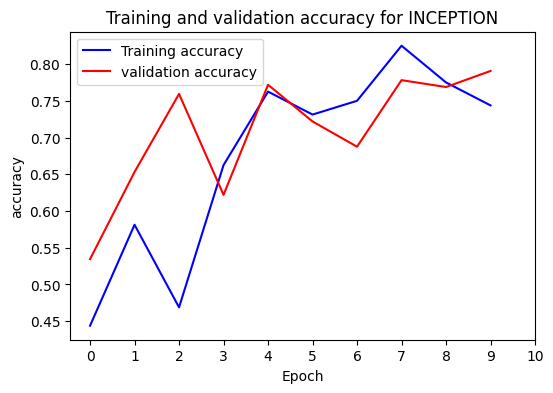

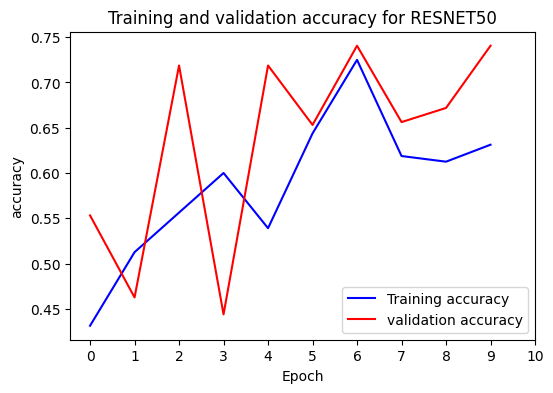

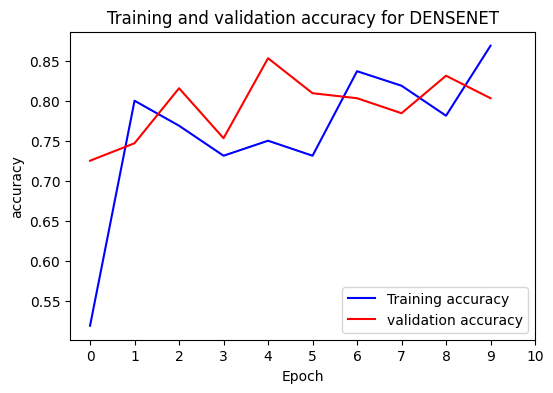

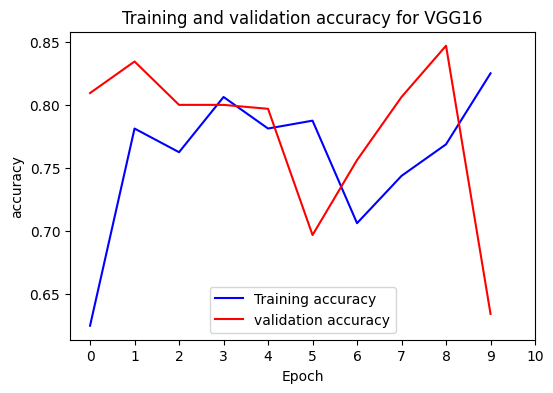

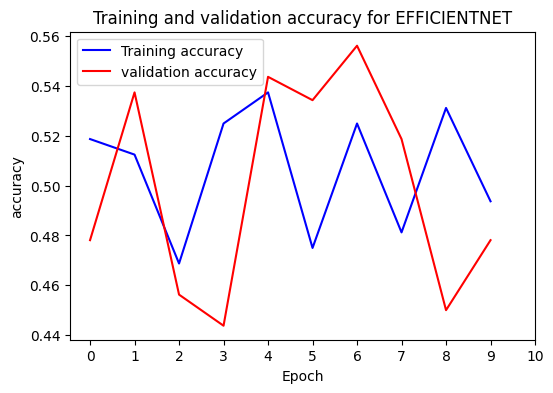

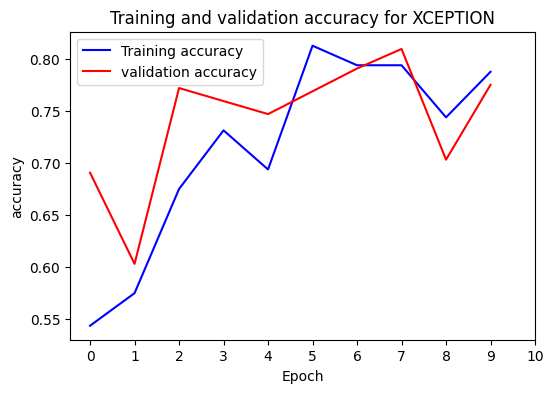

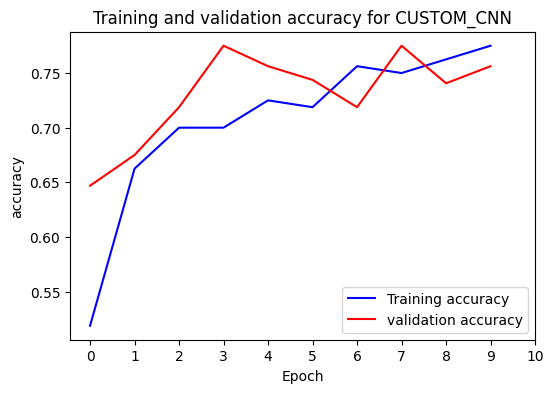

In [30]:
for model_name, history in model_histories.items():
    plt.figure(figsize=(6, 4))
    plt.plot(history['accuracy'], label='Training accuracy',c='blue')
    plt.plot(history['val_accuracy'], label='validation accuracy',c='red')
    plt.title(f'Training and validation accuracy for {model_name.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')

    # Set x-axis ticks with a specific range and increment
    plt.xticks(range(0, len(history['loss']) + 1, 1))  # 1 to 20 with +1 increment

    plt.legend()
    plt.show()


<ipython-input-27-2a9d296f9d77>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['accuracy'],'go--',c='red',)


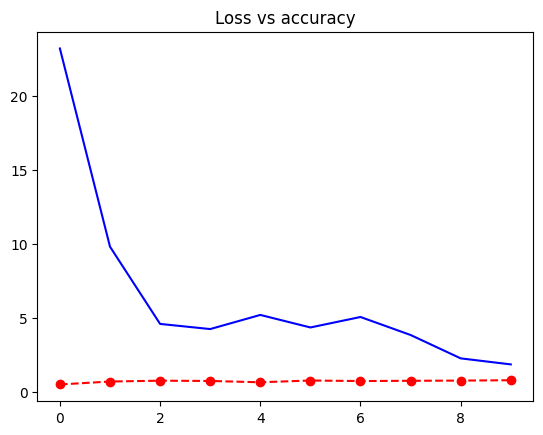

In [ ]:
plt.plot(h['loss'],c='blue')
plt.plot(h['accuracy'],'go--',c='red',)
plt.title("Loss vs accuracy")
plt.show()

<ipython-input-28-3a86f8f56894>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['val_accuracy'],'go--',c='blue',)


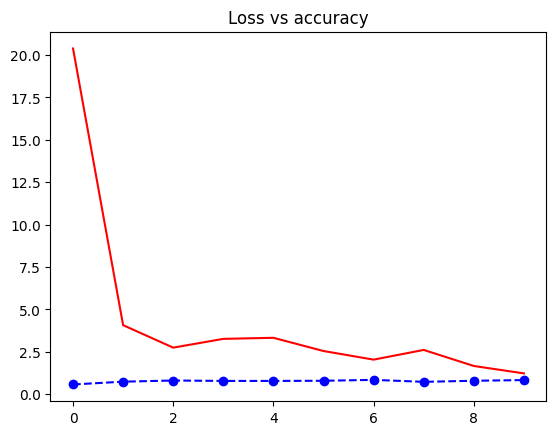

In [ ]:
plt.plot(h['val_loss'],c='red')
plt.plot(h['val_accuracy'],'go--',c='blue',)
plt.title("Loss vs accuracy")
plt.show()

In [31]:
!pip install tabulate


In [49]:
from sklearn.metrics import classification_report
import pandas as pd
from tabulate import tabulate

# Dictionary to store predictions and metrics for all models
model_results = {}

# Function to get classification report for a model
def get_classification_report(model, model_name, test_data):
    # Get model predictions
    y_preds_prob = model.predict(test_data)
    y_preds_binary = np.argmax(y_preds_prob, axis=1)

    # True and predicted labels
    class_labels = ['benign', 'malignant']
    y_true_labels = np.array([class_labels[label] for label in test_data.classes[:len(y_preds_binary)]])
    y_pred_labels = np.array([class_labels[label] for label in y_preds_binary])

    # Generate classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels, output_dict=True)
    model_results[model_name] = report
    return report

# Generate reports for all models
models = {
    "inception": model_inception,
    "resnet50": model_resnet,
    "densenet": model_densenet,
    "vgg16": model_vgg16,
    "efficientnetb0": model_efficientnetb0,
    "xception": model_xception,
    "custom_cnn": model_custom_cnn
}

# Iterate through models and compute classification reports
for model_name, model in models.items():
    get_classification_report(model, model_name, val_data)

# Prepare comparison table
comparison_data = {
    "Model": [],
    "Precision (Benign)": [],
    "Precision (Malignant)": [],
    "Recall (Benign)": [],
    "Recall (Malignant)": [],
    "F1-Score (Benign)": [],
    "F1-Score (Malignant)": [],
    "Accuracy": []
}

for model_name, metrics in model_results.items():
    comparison_data["Model"].append(model_name)
    comparison_data["Precision (Benign)"].append(metrics['benign']['precision'])
    comparison_data["Precision (Malignant)"].append(metrics['malignant']['precision'])
    comparison_data["Recall (Benign)"].append(metrics['benign']['recall'])
    comparison_data["Recall (Malignant)"].append(metrics['malignant']['recall'])
    comparison_data["F1-Score (Benign)"].append(metrics['benign']['f1-score'])
    comparison_data["F1-Score (Malignant)"].append(metrics['malignant']['f1-score'])
    comparison_data["Accuracy"].append(metrics['accuracy'])

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display results in a tabular format
print(tabulate(comparison_df, headers="keys", tablefmt="grid", floatfmt=".2f"))


21/21 [==============================] - 10s 465ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


21/21 [==============================] - 2s 77ms/step
+----+----------------+----------------------+-------------------------+-------------------+----------------------+---------------------+------------------------+------------+
|    | Model          |   Precision (Benign) |   Precision (Malignant) |   Recall (Benign) |   Recall (Malignant) |   F1-Score (Benign) |   F1-Score (Malignant) |   Accuracy |
+====+================+======================+=========================+===================+======================+=====================+========================+============+
|  0 | inception      |                 0.53 |                    0.43 |              0.62 |                 0.34 |                0.57 |                   0.38 |       0.49 |
+----+----------------+----------------------+-------------------------+-------------------+----------------------+---------------------+------------------------+------------+
|  1 | resnet50       |                 0.57 |                    

In [50]:
from sklearn.metrics import classification_report
import pandas as pd

# Dictionary to store predictions and classification reports
classification_reports = {}

# Generate classification report for each model
for model_name, model in models.items():
    print(f"\nGenerating classification report for {model_name}...")
    y_preds_prob = model.predict(
        test_datagen.flow_from_directory(
            '/content/skin-cancer-malignant-vs-benign/test',
            target_size=(256, 256),
            batch_size=1,
            shuffle=False
        )
    )
    y_preds_binary = np.argmax(y_preds_prob, axis=1)

    # Map the true labels to integer values from val_data.classes
    y_true_binary = val_data.classes[:len(y_preds_binary)]  # Match the number of samples

    # Get class indices mapping from the generator
    class_indices = val_data.class_indices
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary

    # Generate and store classification report
    report = classification_report(
        y_true_binary,
        y_preds_binary,
        target_names=list(class_labels.values()),  # Use dynamically retrieved labels
        output_dict=True
    )
    classification_reports[model_name] = report

# Convert classification reports to a tabular format for comparison
report_table = pd.DataFrame.from_dict({
    model_name: {
        f"Precision ({list(class_labels.values())[0]})": report[list(class_labels.values())[0]]["precision"],
        f"Recall ({list(class_labels.values())[0]})": report[list(class_labels.values())[0]]["recall"],
        f"F1-Score ({list(class_labels.values())[0]})": report[list(class_labels.values())[0]]["f1-score"],
        f"Precision ({list(class_labels.values())[1]})": report[list(class_labels.values())[1]]["precision"],
        f"Recall ({list(class_labels.values())[1]})": report[list(class_labels.values())[1]]["recall"],
        f"F1-Score ({list(class_labels.values())[1]})": report[list(class_labels.values())[1]]["f1-score"],
        "Accuracy": report["accuracy"]
    }
    for model_name, report in classification_reports.items()
}, orient='index')

# Display comparison table
print("\nComparison Table of Classification Metrics:")
print(report_table)




Generating classification report for inception...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 51s 78ms/step

Generating classification report for resnet50...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 83s 125ms/step

Generating classification report for densenet...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 71s 108ms/step

Generating classification report for vgg16...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 50s 75ms/step

Generating classification report for efficientnetb0...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 53s 80ms/step

Generating classification report for xception...
Found 660 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


660/660 [==============================] - 79s 120ms/step

Generating classification report for custom_cnn...
Found 660 images belonging to 2 classes.
660/660 [==============================] - 8s 12ms/step

Comparison Table of Classification Metrics:
                Precision (benign)  Recall (benign)  F1-Score (benign)  \
inception                 0.768322         0.902778           0.830140   
resnet50                  0.786550         0.747222           0.766382   
densenet                  0.776498         0.936111           0.848866   
vgg16                     0.603361         0.997222           0.751832   
efficientnetb0            0.000000         0.000000           0.000000   
xception                  0.893993         0.702778           0.786936   
custom_cnn                0.898113         0.661111           0.761600   

                Precision (malignant)  Recall (malignant)  \
inception                    0.852321            0.673333   
resnet50                     0.71

In [61]:
def hello(path, models, histories):
    # Load and preprocess the image
    img = tf.keras.utils.load_img(path, target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)
    input_arr = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the original input image
    original_img = tf.keras.utils.load_img(path)  # Load without resizing for display
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # Initialize variables to store results
    predictions = {}
    validation_accuracies = {}
    max_accuracy_model = None
    max_accuracy = 0

    # Run prediction for each model
    for model_name, model in models.items():
        # Predict using the model
        pred = np.argmax(model.predict(input_arr))
        predictions[model_name] = "benign" if pred == 0 else "malignant"

        # Retrieve validation accuracy directly from the history dictionary
        best_val_accuracy = max(histories[model_name]['val_accuracy'])
        validation_accuracies[model_name] = best_val_accuracy

        # Update the model with the highest validation accuracy
        if best_val_accuracy > max_accuracy:
            max_accuracy = best_val_accuracy
            max_accuracy_model = model_name

    # Print predictions from all models
    print("\nPredictions from all models:")
    for model_name, result in predictions.items():
        print(f"{model_name}: {result} (Val Accuracy: {validation_accuracies[model_name]:.2f})")

    # Display the result from the most accurate model
    print("\nFinal Result:")
    print(f"The most accurate model is {max_accuracy_model} with accuracy {max_accuracy:.2f}.")
    print(f"The prediction is: {predictions[max_accuracy_model]}")




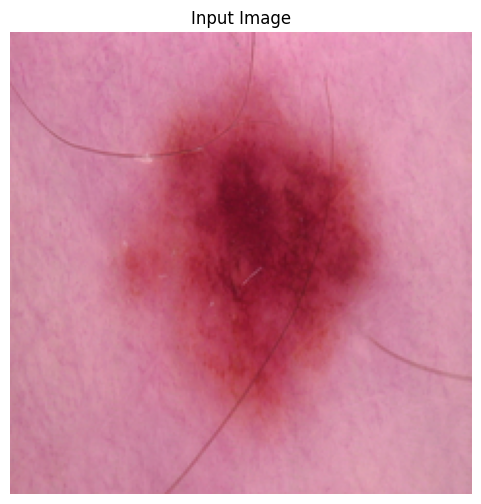

1/1 [==============================] - 0s 41ms/step

Predictions from all models:
inception: benign (Val Accuracy: 0.79)
resnet50: benign (Val Accuracy: 0.74)
densenet: benign (Val Accuracy: 0.85)
vgg16: benign (Val Accuracy: 0.85)
efficientnetb0: malignant (Val Accuracy: 0.56)
xception: benign (Val Accuracy: 0.81)
custom_cnn: benign (Val Accuracy: 0.77)

Final Result:
The most accurate model is densenet with accuracy 0.85.
The prediction is: benign


In [59]:
# Call the hello function with your image
hello('/content/benign5.jpg', models, model_histories)


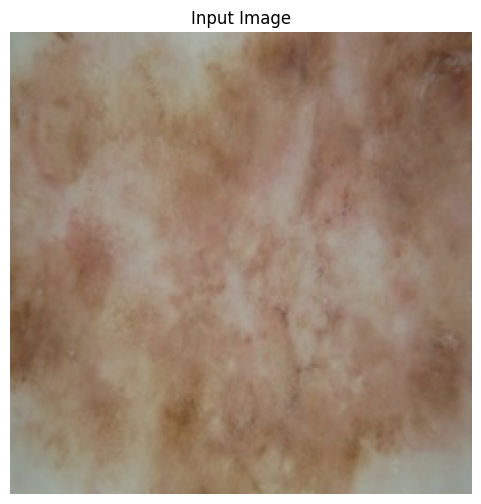

1/1 [==============================] - 0s 37ms/step

Predictions from all models:
inception: malignant (Val Accuracy: 0.79)
resnet50: malignant (Val Accuracy: 0.74)
densenet: malignant (Val Accuracy: 0.85)
vgg16: malignant (Val Accuracy: 0.85)
efficientnetb0: malignant (Val Accuracy: 0.56)
xception: malignant (Val Accuracy: 0.81)
custom_cnn: malignant (Val Accuracy: 0.77)

Final Result:
The most accurate model is densenet with accuracy 0.85.
The prediction is: malignant


In [60]:
# Call the hello function with your image
hello('/content/malignant3.jpg', models, model_histories)

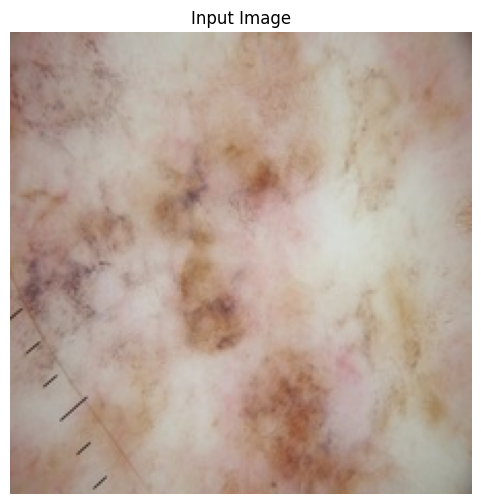

1/1 [==============================] - 0s 36ms/step

Predictions from all models:
inception: malignant (Val Accuracy: 0.79)
resnet50: malignant (Val Accuracy: 0.74)
densenet: malignant (Val Accuracy: 0.85)
vgg16: malignant (Val Accuracy: 0.85)
efficientnetb0: malignant (Val Accuracy: 0.56)
xception: malignant (Val Accuracy: 0.81)
custom_cnn: malignant (Val Accuracy: 0.77)

Final Result:
The most accurate model is densenet with accuracy 0.85.
The prediction is: malignant


In [62]:
# Call the hello function with your image
hello('/content/malignant2.jpg', models, model_histories)

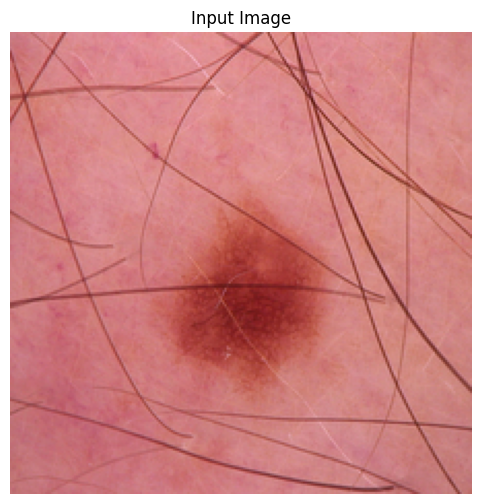

1/1 [==============================] - 0s 37ms/step

Predictions from all models:
inception: benign (Val Accuracy: 0.79)
resnet50: benign (Val Accuracy: 0.74)
densenet: benign (Val Accuracy: 0.85)
vgg16: benign (Val Accuracy: 0.85)
efficientnetb0: malignant (Val Accuracy: 0.56)
xception: benign (Val Accuracy: 0.81)
custom_cnn: benign (Val Accuracy: 0.77)

Final Result:
The most accurate model is densenet with accuracy 0.85.
The prediction is: benign


In [63]:
# Call the hello function with your image
hello('/content/benign6.jpg', models, model_histories)

GRADCAM(ViT)

In [65]:
# Iterate over each model in the models dictionary
for model_name, model in models.items():
    last_conv_layer_name = None
    # Search for the last convolutional layer in the model
    for layer in model.layers[::-1]:  # Reverse the layers to check from the last one
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
            last_conv_layer_name = layer.name
            break

    # Output the last convolutional layer name if found
    if last_conv_layer_name is not None:
        print(f"Model: {model_name} | Last convolutional layer name: {last_conv_layer_name}")
    else:
        print(f"Model: {model_name} | No convolutional layer found")


Model: inception | Last convolutional layer name: conv2d_93
Model: resnet50 | Last convolutional layer name: conv5_block3_3_conv
Model: densenet | Last convolutional layer name: conv5_block16_2_conv
Model: vgg16 | Last convolutional layer name: block5_conv3
Model: efficientnetb0 | Last convolutional layer name: top_conv
Model: xception | Last convolutional layer name: block14_sepconv2
Model: custom_cnn | Last convolutional layer name: conv2d_100


In [77]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

# Preprocessing function (assuming it has been defined)
def preprocess_input(img):
    return tf.keras.applications.inception_v3.preprocess_input(img)  # Example for InceptionV3

# Get image array for prediction
def get_img_arr(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
    img = tf.keras.utils.img_to_array(img)
    img = preprocess_input(img)
    img = np.array([img])
    return img

# Create Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Save and display Grad-CAM superimposed image
def save_and_display_gradcam(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    img = tf.keras.utils.img_to_array(tf.keras.utils.load_img(img_path, target_size=(256, 256)))
    heatmap = np.nan_to_num(heatmap)  # Handle NaN values
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

# Image prediction and visualization
def image_prediction_and_visualization(path, models, model_histories):
    img_array = get_img_arr(path)

    # Loop through each model and process predictions & Grad-CAM
    for model_name, model in models.items():
        print(f"Processing {model_name}...")

        # Initialize last_conv_layer_name variable
        last_conv_layer_name = None

        # Get the last convolutional layer based on model
        for layer in model.layers[::-1]:  # Reverse the layers to check from the last one
            if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
                last_conv_layer_name = layer.name
                break

        # Ensure the last convolutional layer name is assigned
        if last_conv_layer_name is None:
            print(f"Error: No last convolutional layer found for {model_name}")
            continue

        print(f"Last convolutional layer for {model_name}: {last_conv_layer_name}")

        # Create heatmap using Grad-CAM
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Plot the heatmap
        plt.imshow(heatmap)
        plt.title(f"{model_name} - Heatmap")
        plt.show()

        # Predict the class of the image using the model
        pred = np.argmax(model.predict(img_array))
        class_label = "benign" if pred == 0 else "malignant"
        print(f"{model_name} Prediction: {class_label}")

        # Save and display the Grad-CAM superimposed image
        save_and_display_gradcam(path, heatmap, cam_path=f'{model_name}_cam.jpg')

        # Show original image
        a = plt.imread(path)
        plt.imshow(a, cmap='gray')
        plt.title(f"{model_name} - Original Image")
        plt.show()


Processing inception...
Last convolutional layer for inception: conv2d_93


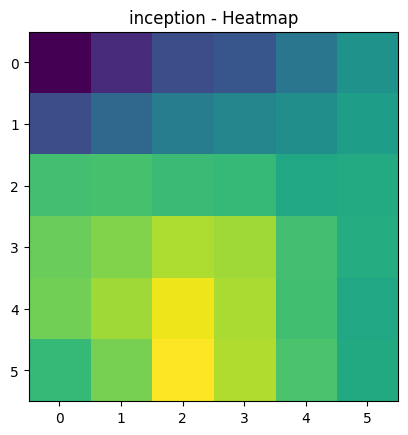

1/1 [==============================] - 0s 110ms/step
inception Prediction: malignant


<ipython-input-70-41cb2e58b933>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


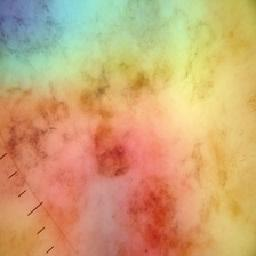

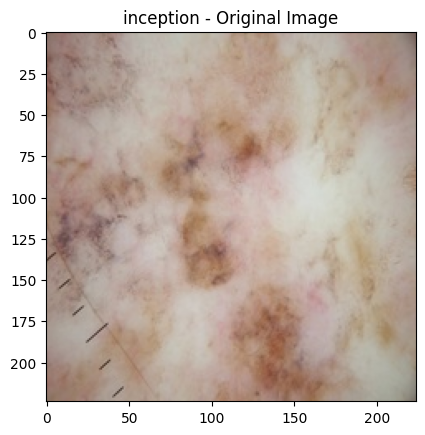

Processing resnet50...
Last convolutional layer for resnet50: conv5_block3_3_conv


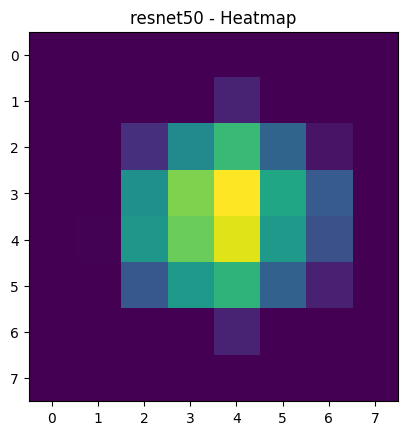

1/1 [==============================] - 0s 158ms/step
resnet50 Prediction: malignant


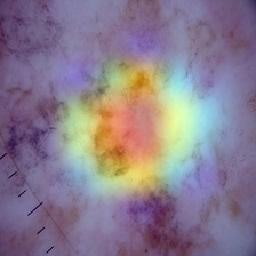

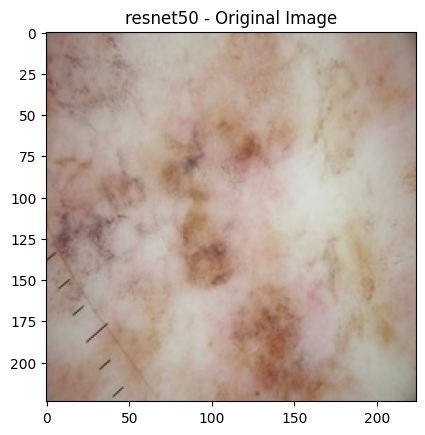

Processing densenet...
Last convolutional layer for densenet: conv5_block16_2_conv


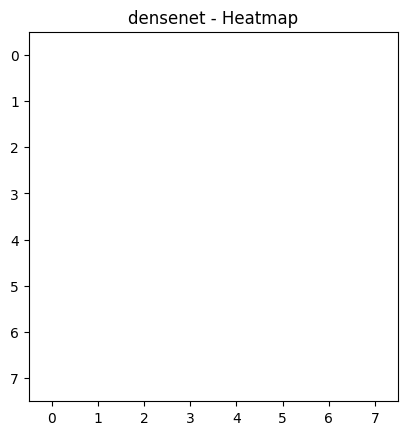

1/1 [==============================] - 0s 139ms/step
densenet Prediction: malignant


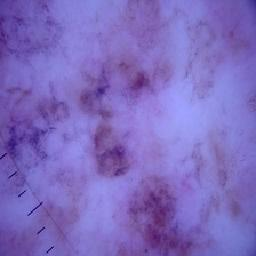

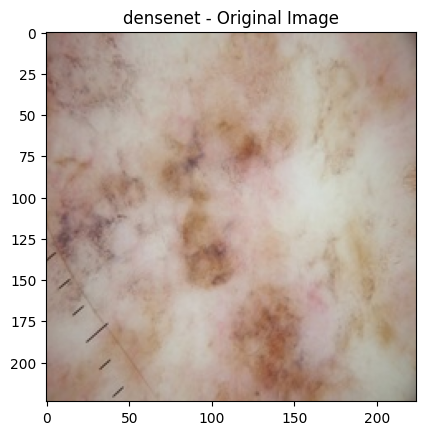

Processing vgg16...
Last convolutional layer for vgg16: block5_conv3


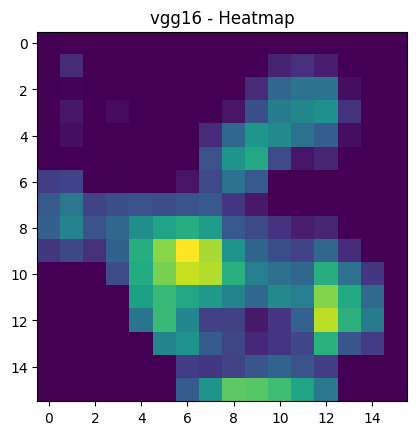

1/1 [==============================] - 0s 109ms/step
vgg16 Prediction: malignant


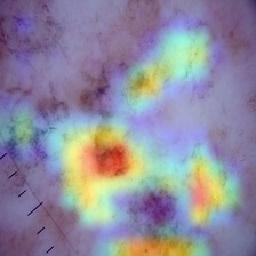

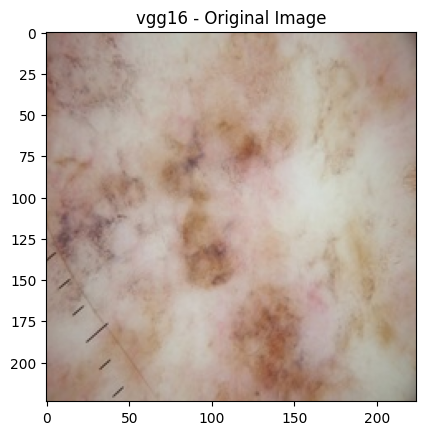

Processing efficientnetb0...
Last convolutional layer for efficientnetb0: top_conv


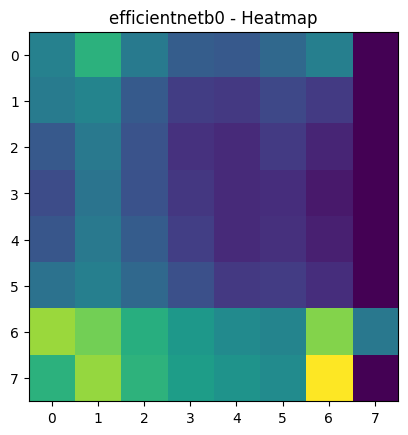

1/1 [==============================] - 0s 108ms/step
efficientnetb0 Prediction: malignant


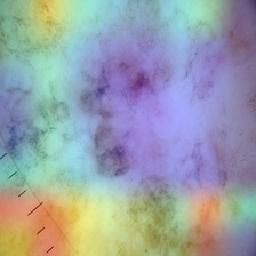

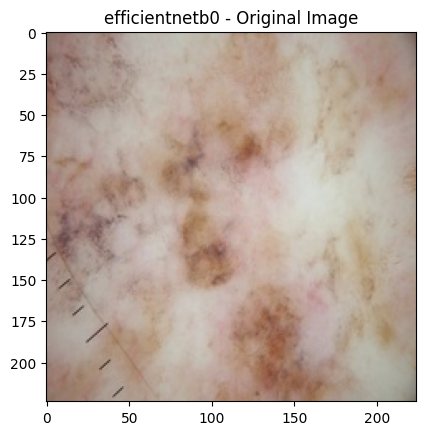

Processing xception...
Last convolutional layer for xception: block14_sepconv2


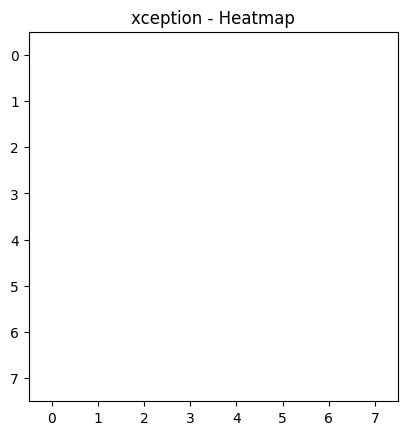

1/1 [==============================] - 0s 149ms/step
xception Prediction: malignant


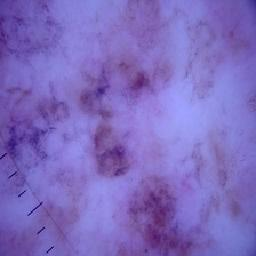

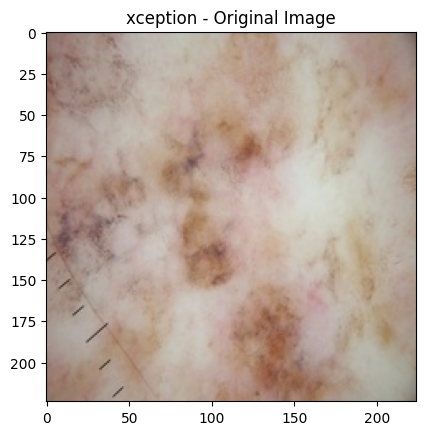

Processing custom_cnn...
Last convolutional layer for custom_cnn: conv2d_100


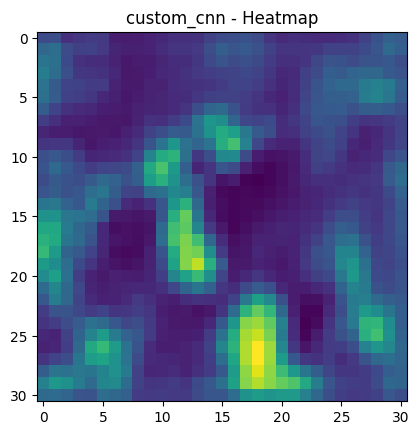

1/1 [==============================] - 0s 39ms/step
custom_cnn Prediction: malignant


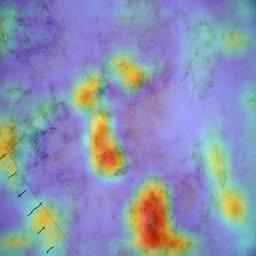

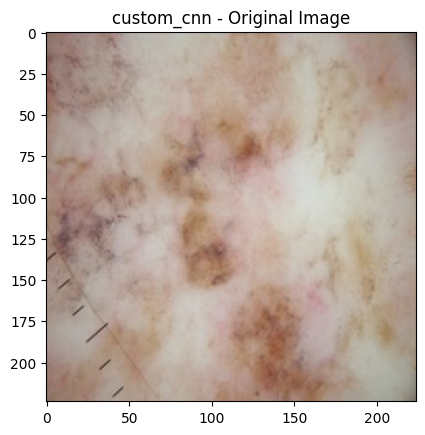

In [73]:
# Example usage with your models and histories
image_path = '/content/malignant2.jpg'
image_prediction_and_visualization(image_path, models, model_histories)


Processing inception...
Last convolutional layer for inception: conv2d_93


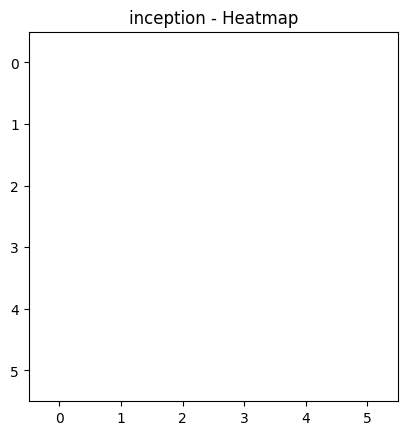

1/1 [==============================] - 0s 104ms/step
inception Prediction: malignant


<ipython-input-70-41cb2e58b933>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


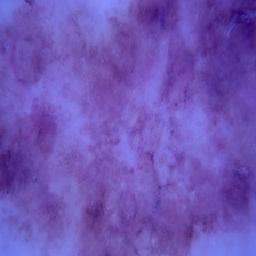

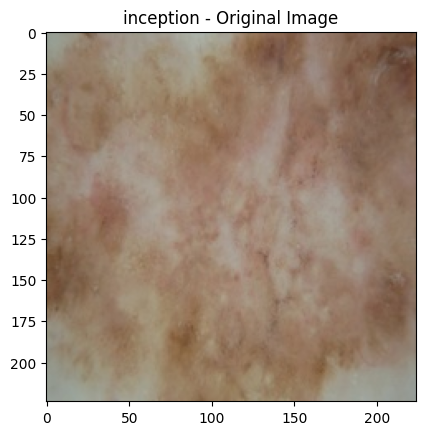

Processing resnet50...
Last convolutional layer for resnet50: conv5_block3_3_conv


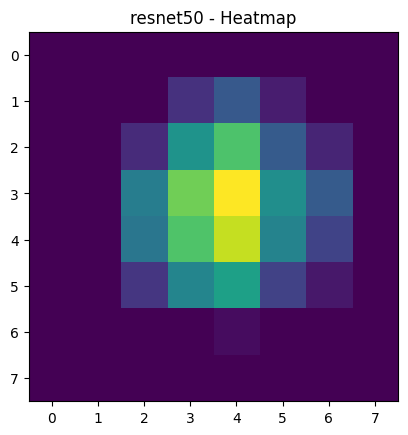

1/1 [==============================] - 0s 150ms/step
resnet50 Prediction: malignant


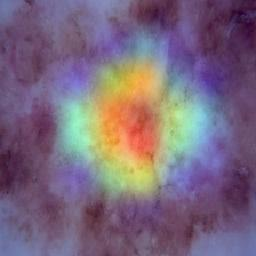

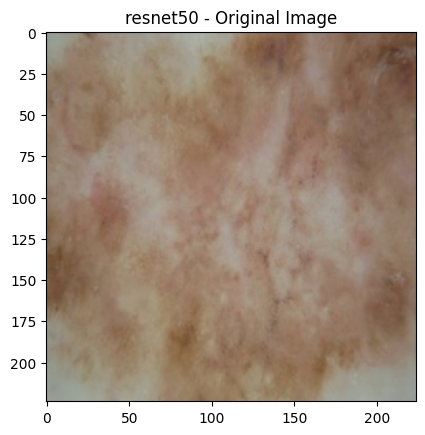

Processing densenet...
Last convolutional layer for densenet: conv5_block16_2_conv


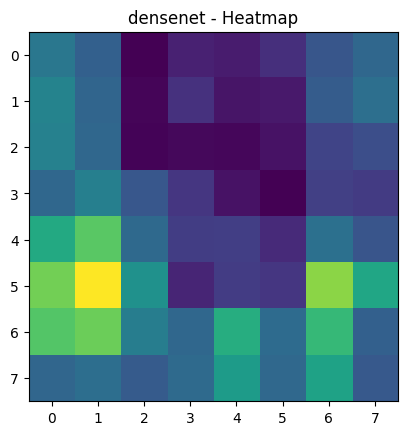

1/1 [==============================] - 0s 135ms/step
densenet Prediction: malignant


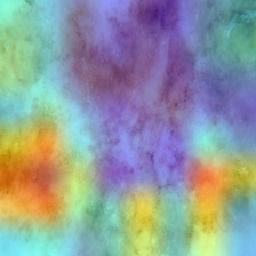

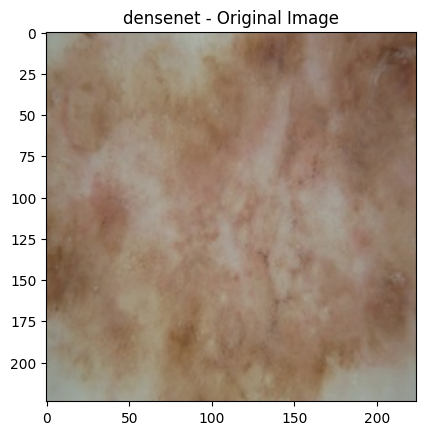

Processing vgg16...
Last convolutional layer for vgg16: block5_conv3


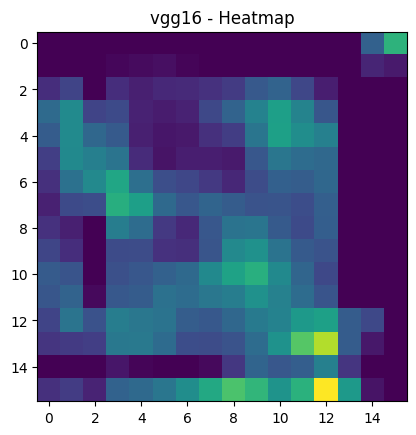

1/1 [==============================] - 0s 102ms/step
vgg16 Prediction: malignant


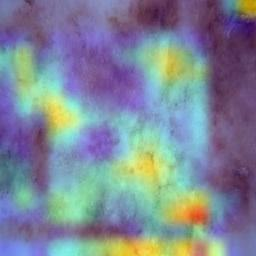

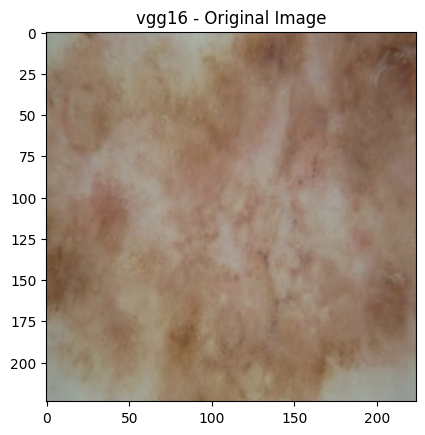

Processing efficientnetb0...
Last convolutional layer for efficientnetb0: top_conv


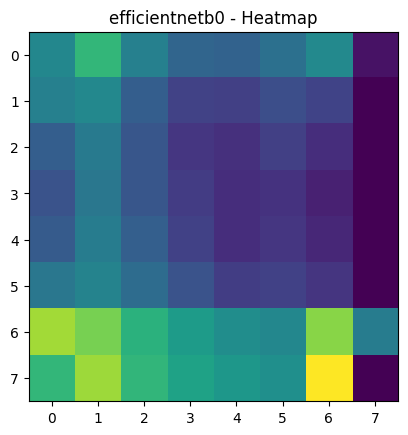

1/1 [==============================] - 0s 108ms/step
efficientnetb0 Prediction: malignant


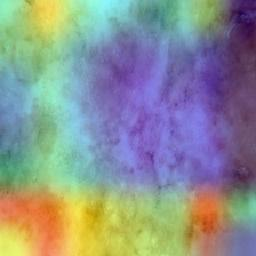

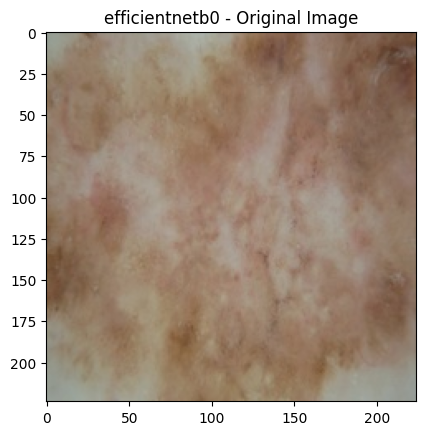

Processing xception...
Last convolutional layer for xception: block14_sepconv2


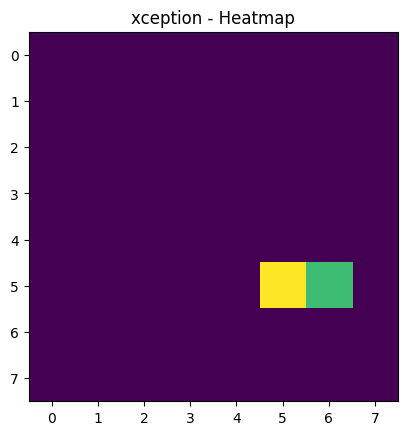

1/1 [==============================] - 0s 160ms/step
xception Prediction: malignant


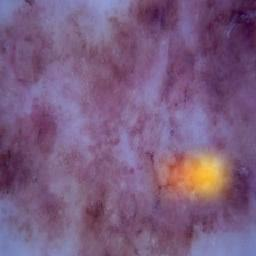

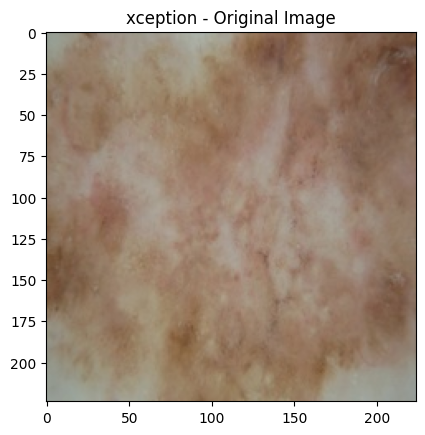

Processing custom_cnn...
Last convolutional layer for custom_cnn: conv2d_100


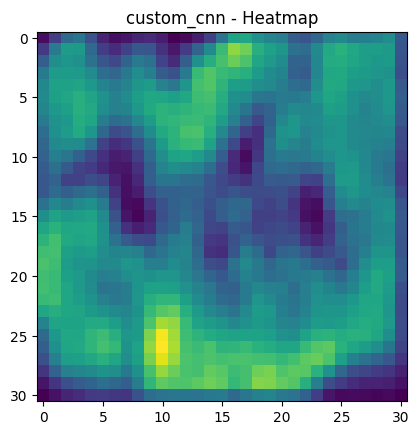

1/1 [==============================] - 0s 39ms/step
custom_cnn Prediction: malignant


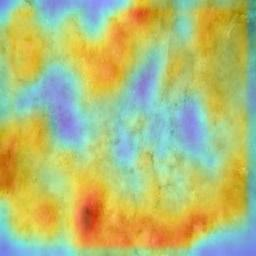

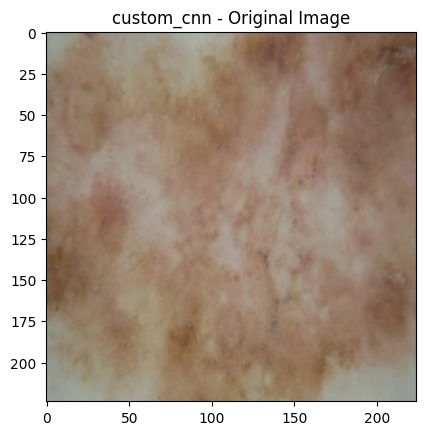

In [71]:

# Example usage with your models and histories
image_path = '/content/malignant3.jpg'
image_prediction_and_visualization(image_path, models, model_histories)


Processing inception...
Last convolutional layer for inception: conv2d_93


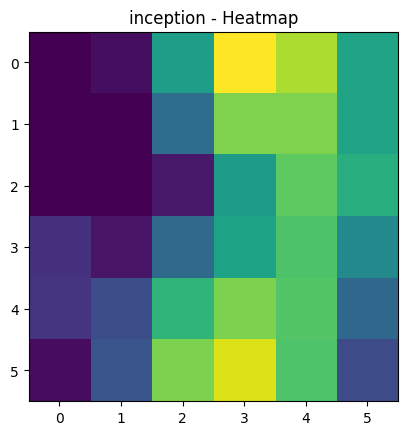

1/1 [==============================] - 0s 109ms/step
inception Prediction: benign


<ipython-input-70-41cb2e58b933>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


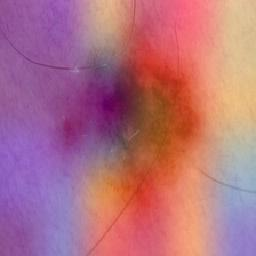

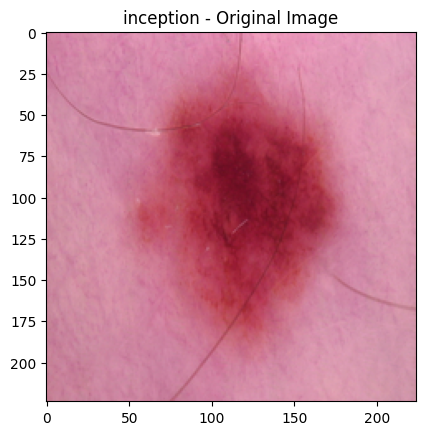

Processing resnet50...
Last convolutional layer for resnet50: conv5_block3_3_conv


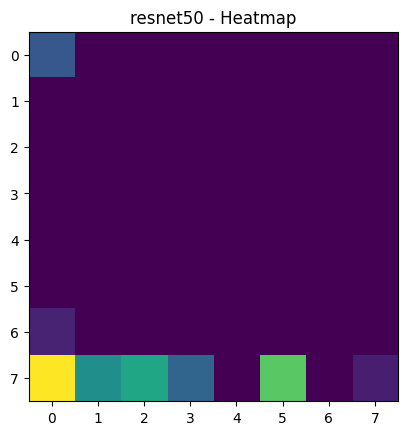

1/1 [==============================] - 0s 166ms/step
resnet50 Prediction: benign


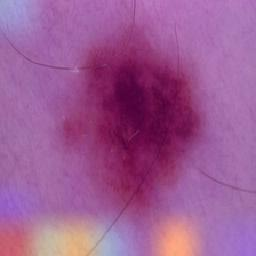

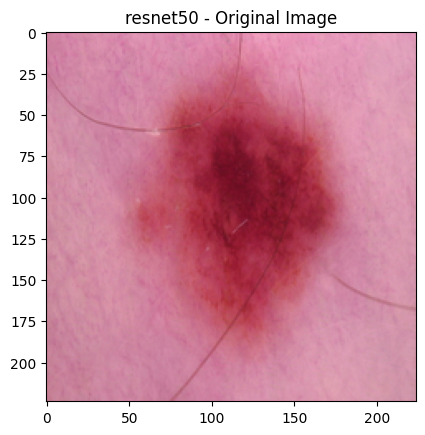

Processing densenet...
Last convolutional layer for densenet: conv5_block16_2_conv


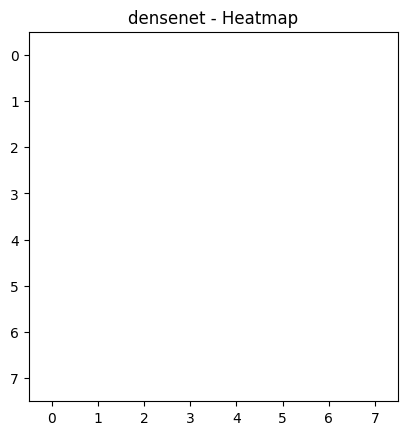

1/1 [==============================] - 0s 137ms/step
densenet Prediction: benign


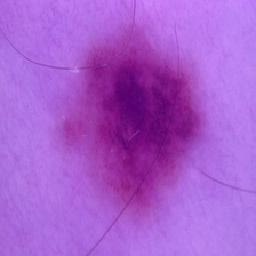

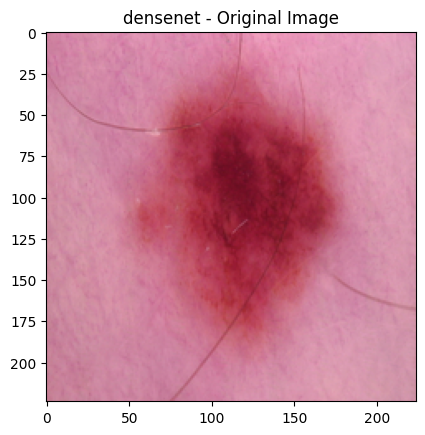

Processing vgg16...
Last convolutional layer for vgg16: block5_conv3


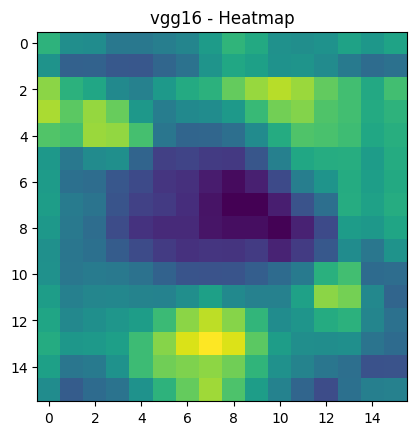

1/1 [==============================] - 0s 118ms/step
vgg16 Prediction: benign


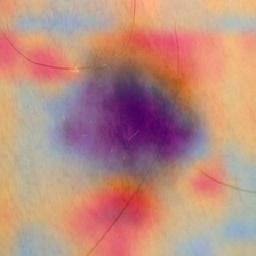

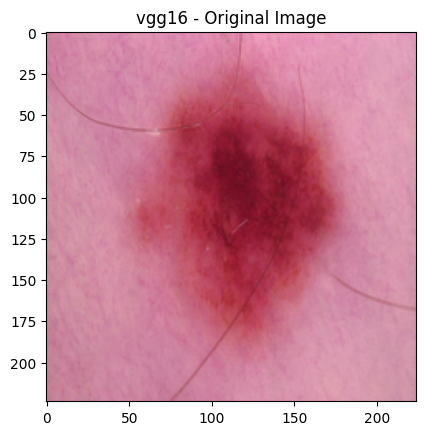

Processing efficientnetb0...
Last convolutional layer for efficientnetb0: top_conv


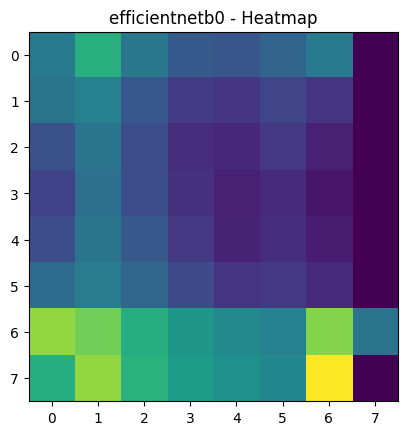

1/1 [==============================] - 0s 106ms/step
efficientnetb0 Prediction: malignant


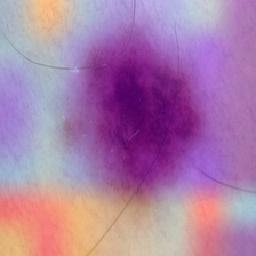

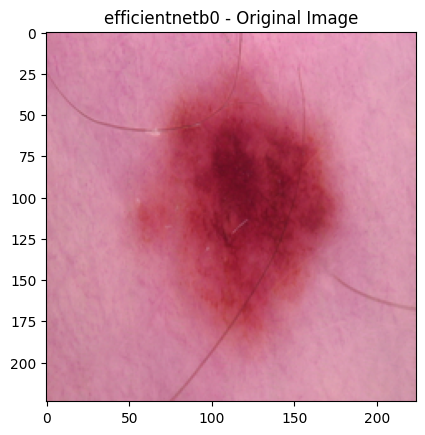

Processing xception...
Last convolutional layer for xception: block14_sepconv2


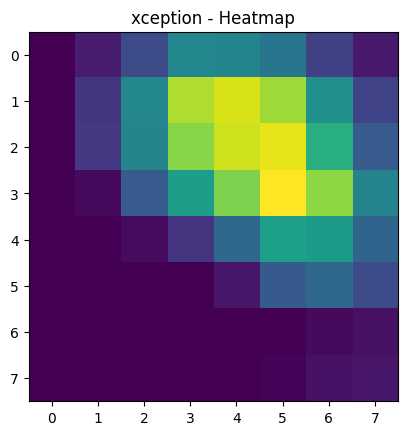

1/1 [==============================] - 0s 154ms/step
xception Prediction: benign


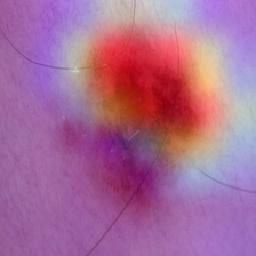

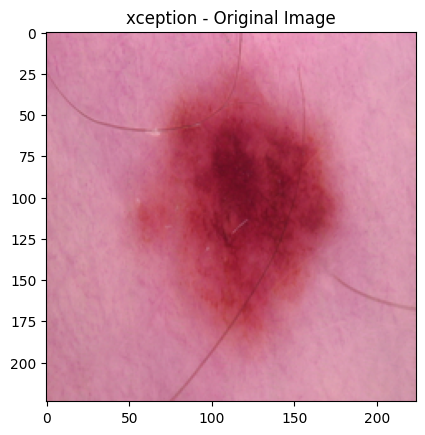

Processing custom_cnn...
Last convolutional layer for custom_cnn: conv2d_100


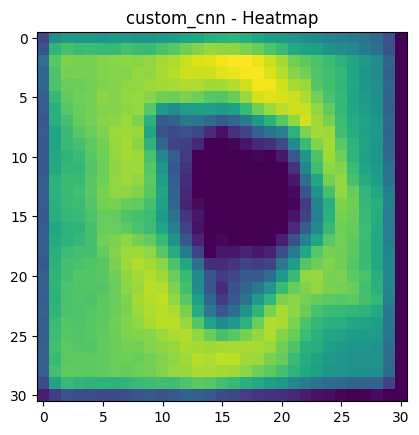

1/1 [==============================] - 0s 42ms/step
custom_cnn Prediction: benign


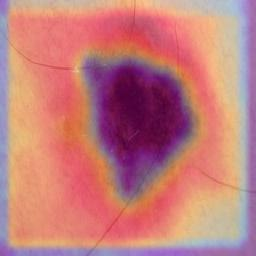

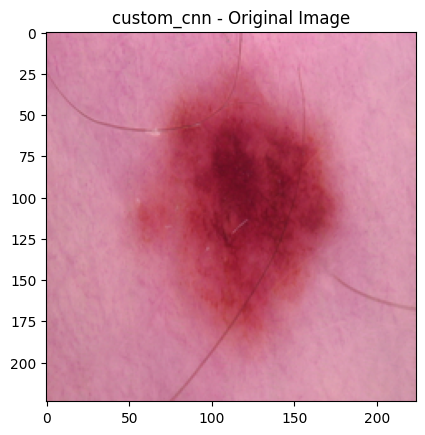

In [72]:
# Example usage with your models and histories
image_path = '/content/benign5.jpg'
image_prediction_and_visualization(image_path, models, model_histories)
